In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # seaborn is a statistical data visualization library
import pandas as pd # pandas is the data analysis and visualization library
import statsmodels.api as sm
import math
from IPython.display import display, HTML
%matplotlib inline

In [10]:
##### FUNCTIONS #####
def findYoungs(origLeng, slopeToE, xSectArea):
    return (origLeng / xSectArea) * slopeToE

def findXSectArea(wireDiameter):
    return math.pi * math.pow(wireDiameter / 2, 2)

def findRigidMod(wireDiameter, coilDiameter, turnNumber, slopeToE):
    return (8 * math.pow(coilDiameter, 3) * turnNumber * slopeToE) / math.pow(wireDiameter, 4)

def youngsToRigidMod(youngsMod, poissonsRat):
    return youngsMod / (2 * (1 + poissonsRat))

def findAttributeValue(attributeString, valueIndicator):
    attributeString = attributeString.replace("-", ".")
    attributeValue = ""
    attributeReached = False
    for i, c in enumerate(attributeString):
        if(attributeReached):
            if(c.isdigit()):
                attributeValue += c
            else:
                attributeReached = False
        elif(c == valueIndicator):
            attributeReached = True
    return np.float64(attributeValue)

In [11]:
##### GLOBAL VARIABLES #####
dataDirectoryList = ["TensionTests/CoilDiameter/", "TensionTests/SpringLength/", "TensionTests/TurnNumber/", "TensionTests/WireDiameter/"] # directory where data is stored
fileListNames = ["files_t0.txt", "files_t1.txt", "files_t2.txt", "files_t3.txt"]
csvHeaders = ["Time", "Extension", "Load"]
headerLines = 9
zeroIndexed = True
errorMargin = 0.05

# decide variables (make sure they are COLUMN HEADERS IN THE FOLLOWING DATAFRAME)
independentVar = "Extension" 
dependentVar = "Load"

sParams = ["CoilDiameter", "SpringLength", "TurnNumber", "WireDiameter"]
paramVals = pd.DataFrame([[25, 30, 50, 60], [25, 45, 65, 85], [4, 6, 8, 10], [2, 3.4, 4.8]], index=sParams)

In [12]:
%%cmd # windows machines
dir TensionTests\CoilDiameter /B > files_t0.txt
dir TensionTests\SpringLength /B > files_t1.txt
dir TensionTests\TurnNumber /B > files_t2.txt
dir TensionTests\WireDiameter /B > files_t3.txt

Microsoft Windows [Version 10.0.17134.254]
(c) 2018 Microsoft Corporation. All rights reserved.

(base) C:\Users\MeOne\Documents\Ondule\TensionTestBarChartCode>dir TensionTests\CoilDiameter /B > files_t0.txt

(base) C:\Users\MeOne\Documents\Ondule\TensionTestBarChartCode>dir TensionTests\SpringLength /B > files_t1.txt

(base) C:\Users\MeOne\Documents\Ondule\TensionTestBarChartCode>dir TensionTests\TurnNumber /B > files_t2.txt

(base) C:\Users\MeOne\Documents\Ondule\TensionTestBarChartCode>dir TensionTests\WireDiameter /B > files_t3.txt

(base) C:\Users\MeOne\Documents\Ondule\TensionTestBarChartCode>

In [ ]:
%%bash # mac/linux machines
ls -1 TensionTests/CoilDiameter > files_t0.txt
ls -1 TensionTests/SpringLength > files_t1.txt
ls -1 TensionTests/TurnNumber > files_t2.txt
ls -1 TensionTests/WireDiameter > files_t3.txt

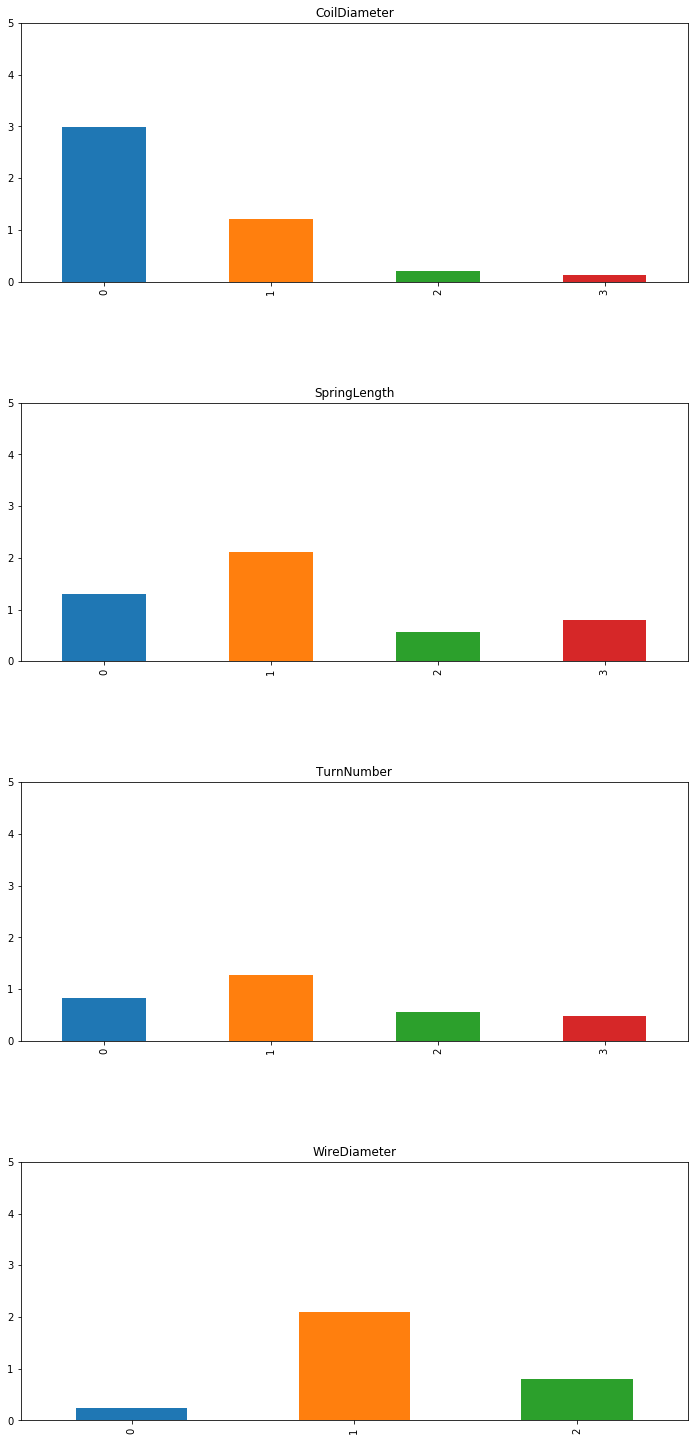

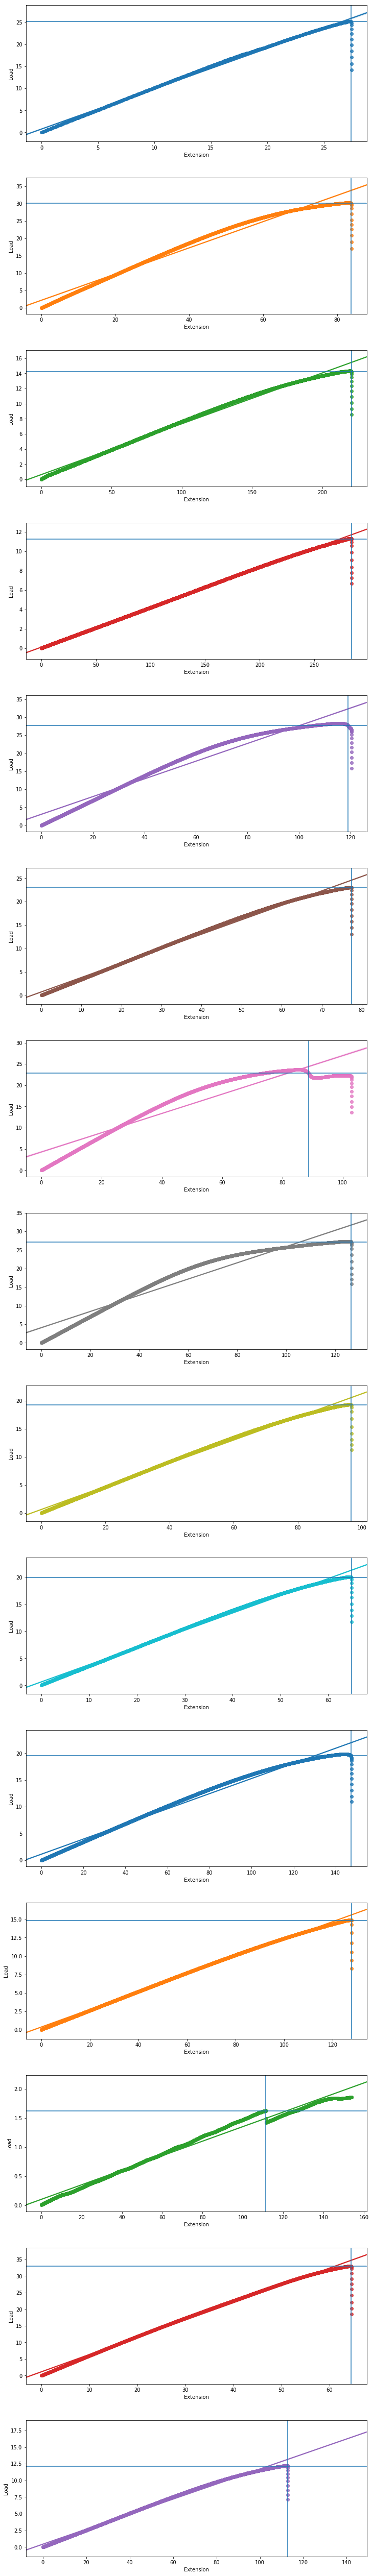

In [16]:
# axes for bar plots
fig, axes = plt.subplots(nrows=len(dataDirectoryList), ncols=1, figsize=(10, 20))
fig.tight_layout(h_pad=10)

# cumulative lists of information
cumulativeEList = []
cumulativeGList = []
cumulativeNames = []
cumulativeMeans = []
cumulativeStds = []

# axes for scatter plots 
fig2, axes2 = plt.subplots(nrows=paramVals.size - 1, ncols=1, figsize=(10, 70))
fig2.tight_layout(h_pad=5)
initGraphIndex = 0

for testGroup in range(len(dataDirectoryList)):
    # parse and read through all files
    fileList = pd.read_csv(fileListNames[testGroup], sep="\n", header=None, squeeze=True);
    fileList.tolist() # we don't need the extensive capabilities of a Series
    dataList = []
    nameList = []
    for filename in fileList:
        dataList.append(pd.read_csv(dataDirectoryList[testGroup] + filename, names=csvHeaders, skiprows=headerLines))
        tempName = pd.read_csv(dataDirectoryList[testGroup] + filename, header=None, skiprows=1, nrows=1, usecols=[1], squeeze=True)
        nameList.append(tempName[0])
    cumulativeNames += nameList
    
    # find the position of the elastic modulus
    EInfoList = []
    for dataset in dataList:
        currIndex = 0
        currLoad = dataset.at[currIndex, dependentVar]
        nextLoad = dataset.at[currIndex + 1, dependentVar] + errorMargin

        # find the location of E
        while currIndex < dataset.shape[0] - 2 and currLoad < nextLoad:
            currIndex += 1
            currLoad = dataset.at[currIndex, dependentVar]
            nextLoad = dataset.loc[currIndex + 1, dependentVar] + errorMargin

        # load the information into a dictionary
        EInfoList.append(dict(maxLoad=currLoad, maxExt=dataset.at[currIndex, independentVar], maxIndex=currIndex, csvIndex=currIndex + headerLines + zeroIndexed))
    EInfoDF = pd.DataFrame(EInfoList) # put the gathered information into a DataFrame
    EInfoDF.loc[:, "attributeName"] = nameList # add names to DataFrame as new column
    
    # plot data and find the linear approximation to the elastic modulus
    regLineInfoList = []
    for i in range(len(dataList)): 
        independentCol = dataList[i].loc[0:EInfoDF.at[i, "maxIndex"], independentVar]
        dependentCol = dataList[i].loc[0:EInfoDF.at[i, "maxIndex"], dependentVar]
#         sns.regplot(x=independentCol, y=dependentCol, ax=axes2[initGraphIndex + i])
        sns.regplot(data=dataList[i], x=independentVar, y=dependentVar, ax=axes2[initGraphIndex + i])
        axes2[initGraphIndex + i].axhline(y=EInfoDF.at[i, "maxLoad"], xmin=0, xmax=1)
        regModel = sm.OLS(dependentCol, sm.add_constant(independentCol))
        regLineInfo = regModel.fit().params
#         axes2[initGraphIndex + i].scatter(x=independentCol, y=dependentCol, marker=".")
        axes2[initGraphIndex + i].axvline(x=EInfoDF.at[i, "maxExt"], ymin=0, ymax=1)
#         print(regModel.fit().summary())
        cumulativeMeans.append(dependentCol.mean())
        cumulativeStds.append(dependentCol.std())
        regLineInfoList.append(dict(intercept=regLineInfo[0], slope=regLineInfo[1]))
    regLineInfoDF = pd.DataFrame(regLineInfoList) # put the gathered information into a DataFrame for easy access
    EInfoDF.loc[:, "intercept"] = regLineInfoDF.loc[:, "intercept"] # add "intercept" column to previous DataFrame
    EInfoDF.loc[:, "slope"] = regLineInfoDF.loc[:, "slope"] # add "slope" column to previous DataFrame
    initGraphIndex += len(dataList)
    
    # find E
    EList = []
    GList = []
    for test in EInfoDF.index:
        equilibriumL = findAttributeValue(EInfoDF.at[test, "attributeName"], "L")
        avgForce = EInfoDF.at[test, "slope"]
        wireD = findAttributeValue(EInfoDF.at[test, "attributeName"], "d")
        coilD = findAttributeValue(EInfoDF.at[test, "attributeName"], "D") - wireD
        EList.append(findYoungs(equilibriumL, avgForce, findXSectArea(wireD)))
        GList.append(findRigidMod(wireD, coilD, findAttributeValue(EInfoDF.at[test, "attributeName"], "N"), avgForce))
    EInfoDF.loc[:, "elasticMod"] = EList # add "E" column to previous DataFrame
    EInfoDF.loc[:, "rigidMod"] = GList # add "G" column to previous DataFrame
    
    # plot E for all tests
    EInfoDF.loc[:, "elasticMod"].plot(title=sParams[testGroup], kind="bar", ylim=[0, 5], ax=axes[testGroup])
    cumulativeEList += EInfoDF.loc[:, "elasticMod"].tolist()
    cumulativeGList += EInfoDF.loc[:, "rigidMod"].tolist()
cumulativeEDF = pd.DataFrame(data=cumulativeEList, index=cumulativeNames, columns=["Young's Modulus"])
cumulativeEDF["Modulus of Rigidity"] = cumulativeGList
cumulativeEDF["Mean (Load)"] = cumulativeMeans
cumulativeEDF["Standard Deviation (Load)"] = cumulativeStds

In [14]:
# print table of E values and averages of rows and columns
cumulativeEDF.loc["Average"] = cumulativeEDF.mean(numeric_only=True, axis=0).tolist() # add column average row
cumulativeEDF.loc["Standard Deviation"] = cumulativeEDF.std(numeric_only=True, axis=0).tolist() # add column average row
display(HTML(cumulativeEDF.to_html()))

,Young's Modulus,Modulus of Rigidity,Mean (Load),Standard Deviation (Load)
D25L40N5d4,2.987722,1358.213140,13.413841,7.451767
D30L40N5d4,1.214052,1047.435310,18.066562,9.337741
D50L40N5d4,0.214110,1023.013287,8.051391,4.302148
D60L40N5d4,0.130430,1124.373033,5.914826,3.361458
D32L65N5d4,1.299138,861.481682,17.787720,8.815738
D32L85N5d4,2.104961,1067.404701,12.678174,6.977568
D32L25N5d4,0.559173,964.073599,15.028623,7.360707
D32L45N5d4,0.788507,755.261276,17.930887,8.340316
D32L50N6d4,0.824740,853.163966,10.611343,5.803114
D32L50N4d4,1.280298,882.947577,10.997548,6.042736


In [15]:
# clean up
!del files* # windows machines
# !rm -f files* # mac/linux machines